In [1]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "gs://neural-guidance-tensorflow/export/0315_series5a_sr50_l40_aTrue_tng-tpu-pre-20/1552775302/"
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from gs://neural-guidance-tensorflow/export/0315_series5a_sr50_l40_aTrue_tng-tpu-pre-20/1552775302/variables/variables


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
import sys 
sys.path.insert(0,'..')

In [4]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [5]:
import math
from collections import defaultdict

def jw(clauses):
    score = defaultdict(int)

    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))

    return max(score, key=score.get)


In [6]:
LIMIT_RUNS = 1000

In [7]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [8]:
np.set_printoptions(precision=3, suppress=True)

In [9]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [10]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        # print("Chosen neural", best_svar)
        return best_svar

class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]
    
class JeroslawDPLL(DPLL):
    def suggest(self, cnf: CNF):
        return jw(cnf.clauses)

In [11]:
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)
NormalizedJeroslawDPLL = make_normalized(JeroslawDPLL)

In [12]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        # assert res is not None
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [13]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [14]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    compute_and_print_steps(sats, NormalizedJeroslawDPLL)
    logfile.flush()

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [04:58<00:00,  1.59s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.11; stdev step: 6.05; avg error: 0.73; stdev error: 0.76


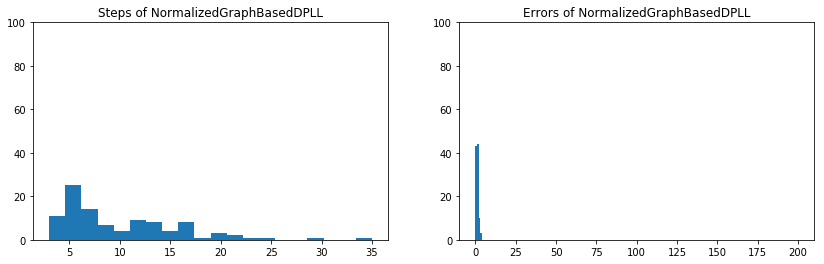

100%|██████████| 100/100 [00:02<00:00, 46.63it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.14; stdev step: 3.90; avg error: 0.86; stdev error: 0.72


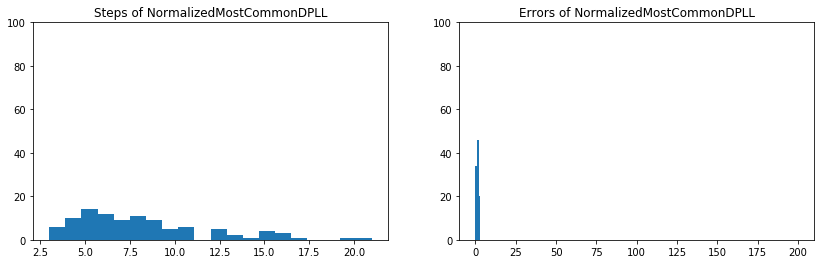

100%|██████████| 100/100 [00:00<00:00, 121.06it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 7.33; stdev step: 3.55; avg error: 0.50; stdev error: 0.57


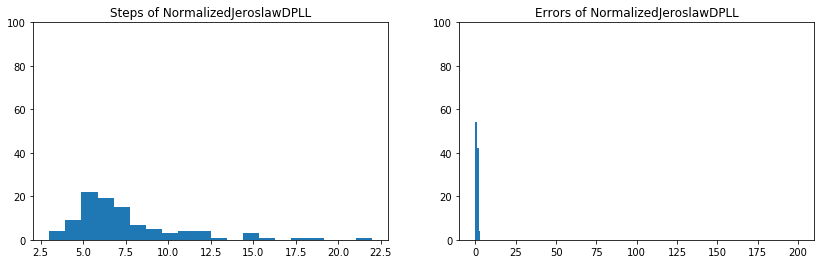

In [15]:
print_all(100, 200, 10)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [05:52<00:00,  3.76s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 16.78; stdev step: 12.41; avg error: 1.11; stdev error: 0.97


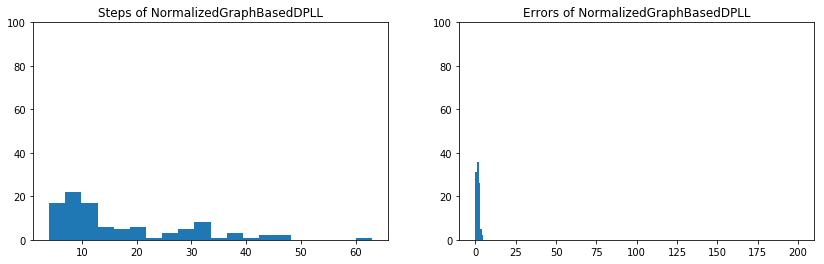

100%|██████████| 100/100 [00:03<00:00, 24.37it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.20; stdev step: 5.41; avg error: 1.06; stdev error: 0.87


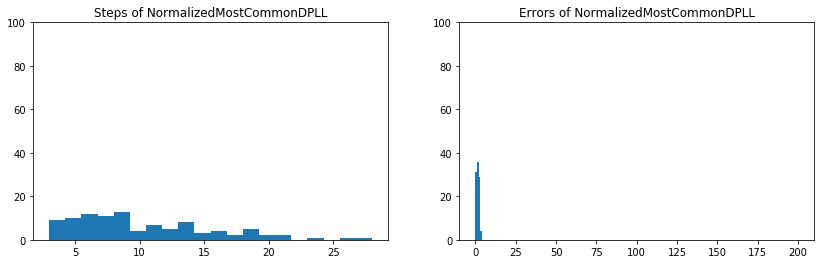

100%|██████████| 100/100 [00:02<00:00, 36.01it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.87; stdev step: 4.89; avg error: 0.64; stdev error: 0.67


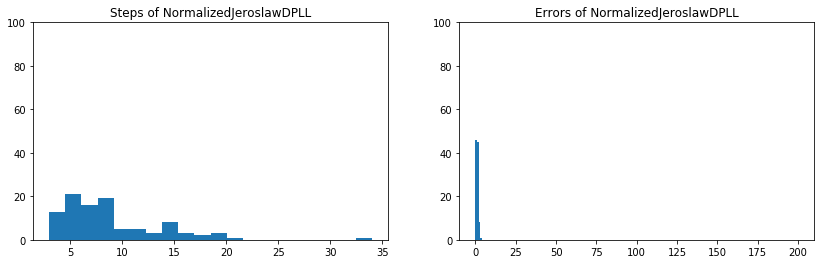

In [16]:
print_all(100, 200, 12)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [09:03<00:00,  5.04s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 24.32; stdev step: 17.09; avg error: 1.44; stdev error: 1.00


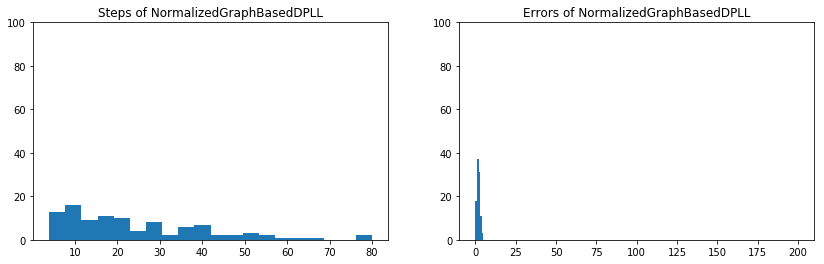

100%|██████████| 100/100 [00:03<00:00, 27.98it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.82; stdev step: 7.62; avg error: 1.14; stdev error: 0.88


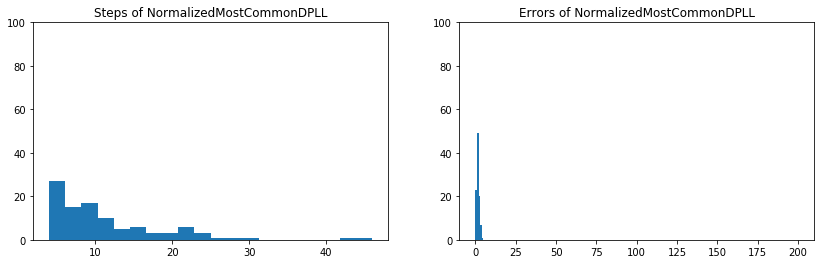

100%|██████████| 100/100 [00:03<00:00, 31.76it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.64; stdev step: 6.20; avg error: 0.80; stdev error: 0.76


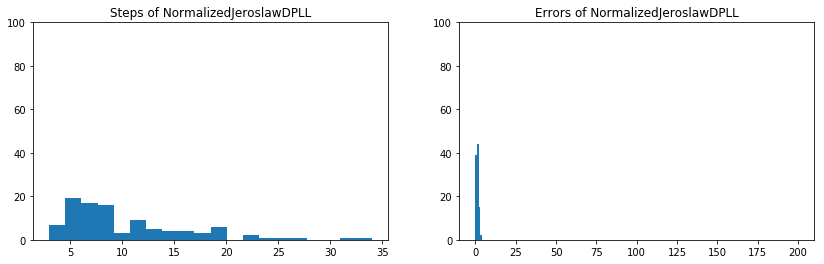

In [17]:
print_all(100, 200, 14)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [12:35<00:00,  6.61s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 31.33; stdev step: 26.08; avg error: 1.46; stdev error: 1.06


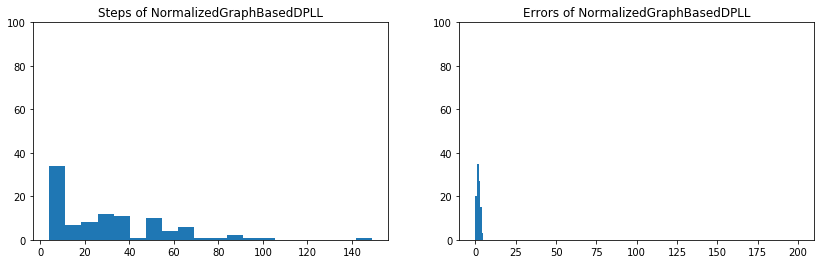

100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 15.46; stdev step: 10.82; avg error: 1.23; stdev error: 0.91


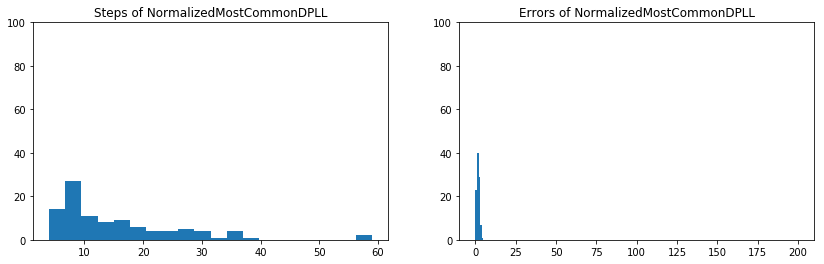

100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.95; stdev step: 6.77; avg error: 0.89; stdev error: 0.66


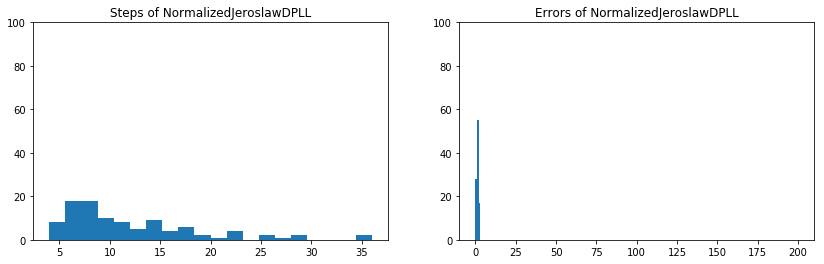

In [18]:
print_all(100, 200, 16)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [19:07<00:00,  7.65s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 45.96; stdev step: 44.25; avg error: 1.78; stdev error: 1.25


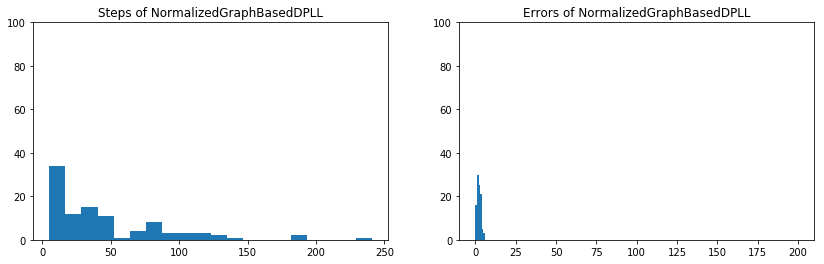

100%|██████████| 100/100 [00:09<00:00, 10.03it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.41; stdev step: 11.64; avg error: 1.41; stdev error: 0.91


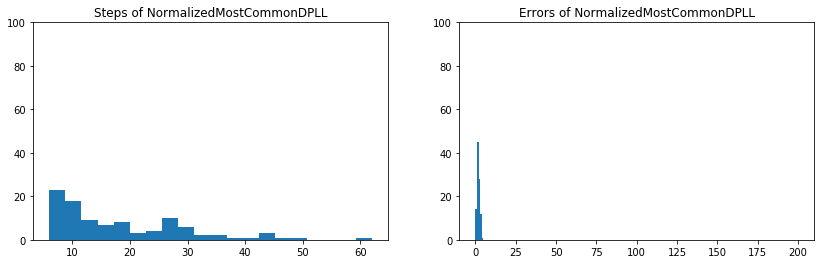

100%|██████████| 100/100 [00:07<00:00, 14.05it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 13.64; stdev step: 7.52; avg error: 0.96; stdev error: 0.76


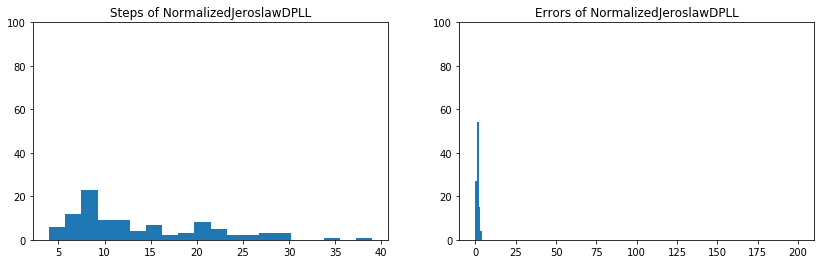

In [19]:
print_all(100, 200, 18)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [28:03<00:00, 28.87s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 64.36; stdev step: 54.68; avg error: 1.94; stdev error: 1.31


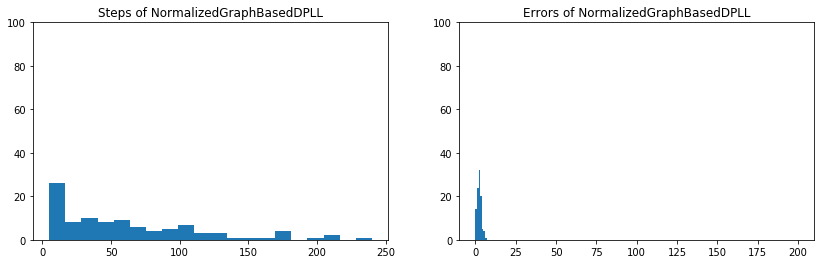

100%|██████████| 100/100 [00:11<00:00,  8.60it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 23.56; stdev step: 17.36; avg error: 1.57; stdev error: 1.05


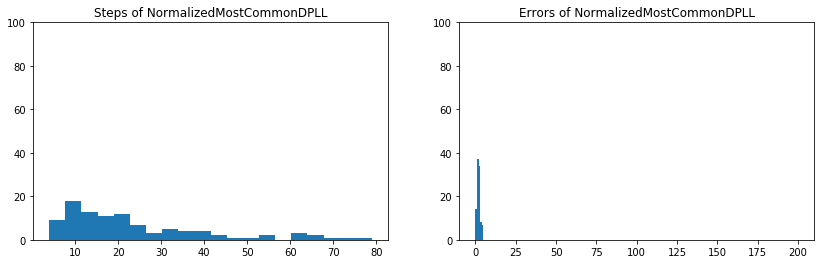

100%|██████████| 100/100 [00:10<00:00,  5.91it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.65; stdev step: 11.41; avg error: 1.14; stdev error: 0.72


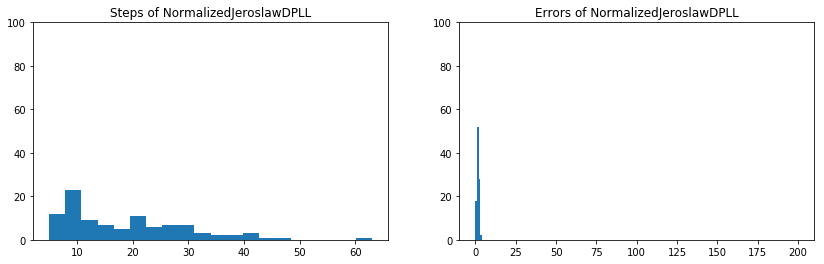

In [20]:
print_all(100, 200, 20)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [59:44<00:00, 29.24s/it]


Within 1000 steps solved 99 problems out of 100
#Sats: 99; avg step: 108.47; stdev step: 108.41; avg error: 2.18; stdev error: 1.32


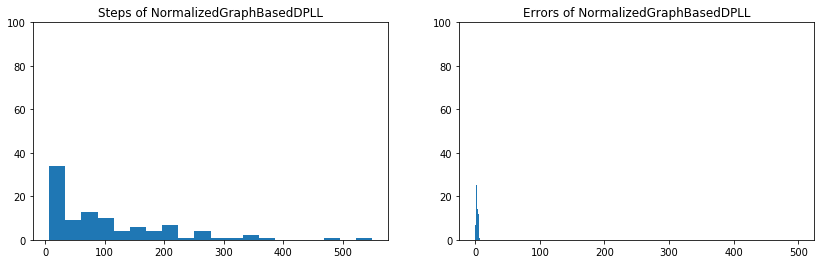

100%|██████████| 100/100 [00:28<00:00,  3.53it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 32.48; stdev step: 30.11; avg error: 1.63; stdev error: 1.14


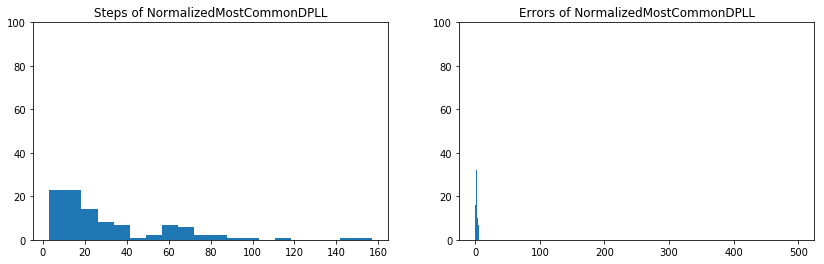

100%|██████████| 100/100 [00:16<00:00,  4.36it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.81; stdev step: 14.61; avg error: 1.03; stdev error: 0.84


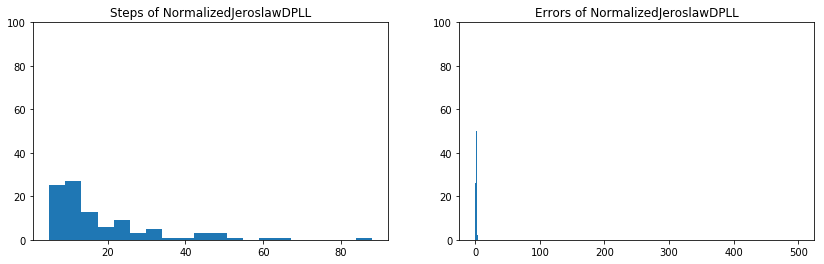

In [21]:
print_all(100, 500, 25, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [2:19:32<00:00, 81.94s/it]


Within 1000 steps solved 96 problems out of 100
#Sats: 96; avg step: 224.54; stdev step: 213.59; avg error: 2.57; stdev error: 1.24


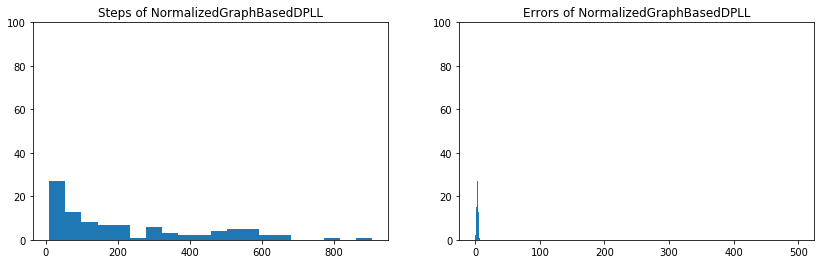

100%|██████████| 100/100 [00:52<00:00,  2.98it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 53.31; stdev step: 48.86; avg error: 2.03; stdev error: 1.19


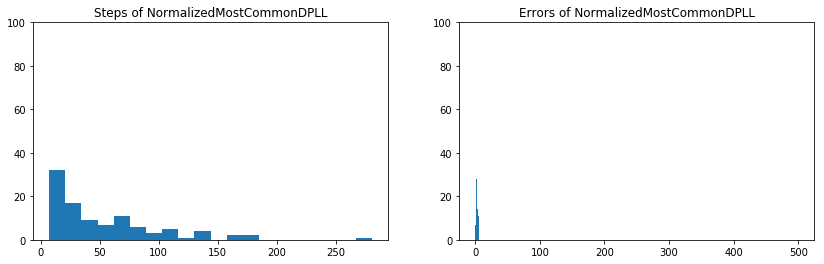

100%|██████████| 100/100 [00:36<00:00,  2.79it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 32.82; stdev step: 26.21; avg error: 1.22; stdev error: 0.79


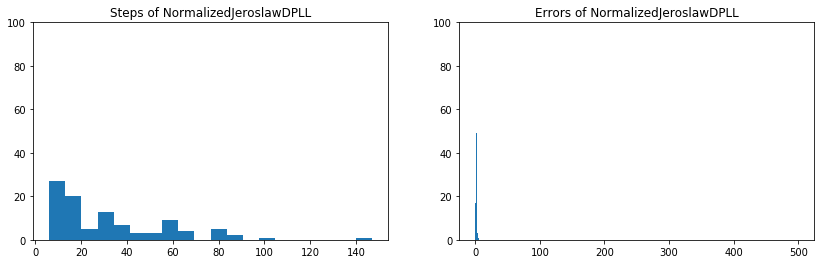

In [22]:
print_all(100, 500, 30, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [7:09:54<00:00, 360.61s/it]


Within 1000 steps solved 52 problems out of 100
#Sats: 52; avg step: 350.67; stdev step: 271.79; avg error: 2.87; stdev error: 1.40


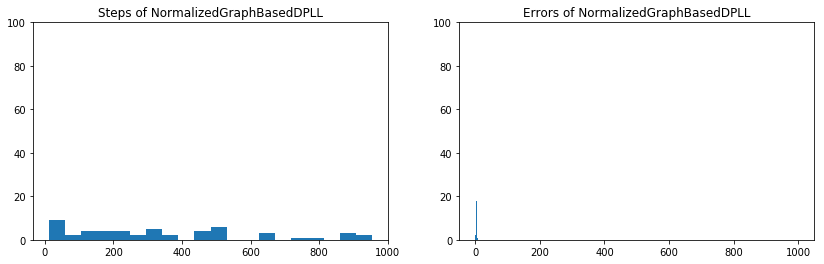

100%|██████████| 100/100 [05:02<00:00,  3.97s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 190.63; stdev step: 167.22; avg error: 2.65; stdev error: 1.32


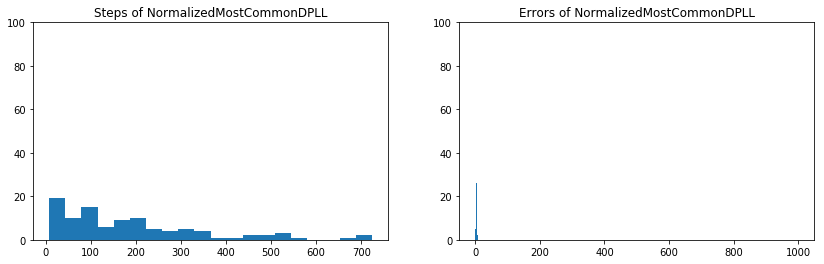

100%|██████████| 100/100 [02:07<00:00,  2.46s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 84.10; stdev step: 73.23; avg error: 1.86; stdev error: 1.08


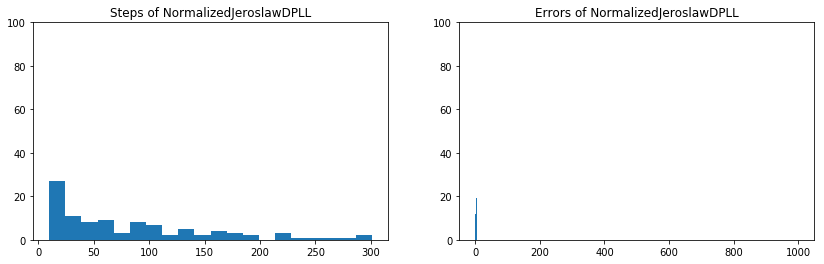

In [23]:
print_all(100, 1000, 40, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [9:13:30<00:00, 379.53s/it]


Within 1000 steps solved 24 problems out of 100
#Sats: 24; avg step: 350.04; stdev step: 278.04; avg error: 2.50; stdev error: 1.26


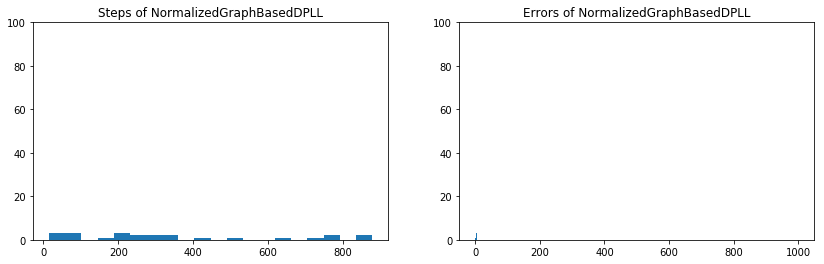

100%|██████████| 100/100 [19:47<00:00, 15.10s/it]


Within 1000 steps solved 85 problems out of 100
#Sats: 85; avg step: 376.07; stdev step: 300.93; avg error: 2.89; stdev error: 1.34


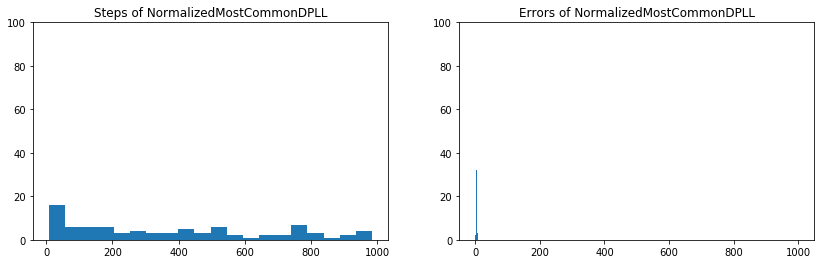

100%|██████████| 100/100 [06:18<00:00,  3.82s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 152.00; stdev step: 146.38; avg error: 2.03; stdev error: 1.10


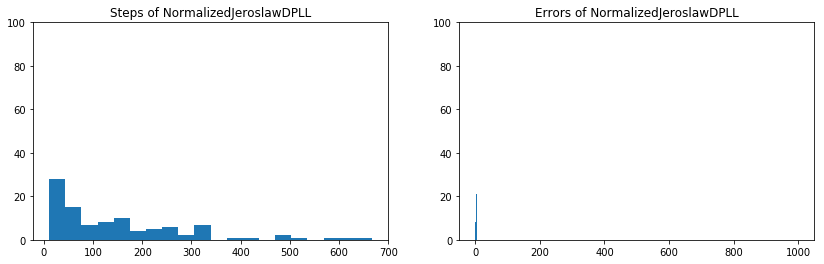

In [24]:
print_all(100, 1000, 50, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [13:27:42<00:00, 507.81s/it]


Within 1000 steps solved 4 problems out of 100
#Sats: 4; avg step: 372.00; stdev step: 274.09; avg error: 2.75; stdev error: 0.83


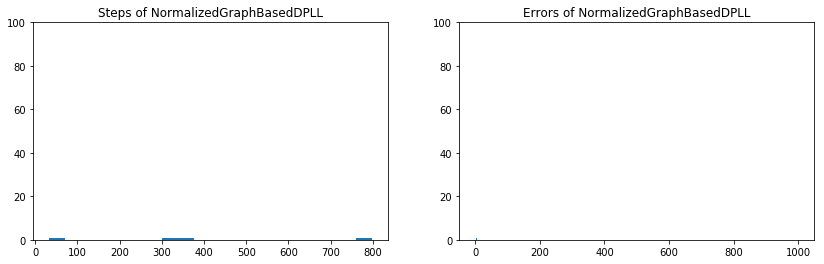

100%|██████████| 100/100 [1:03:14<00:00, 32.20s/it]


Within 1000 steps solved 26 problems out of 100
#Sats: 26; avg step: 505.96; stdev step: 332.60; avg error: 3.62; stdev error: 1.30


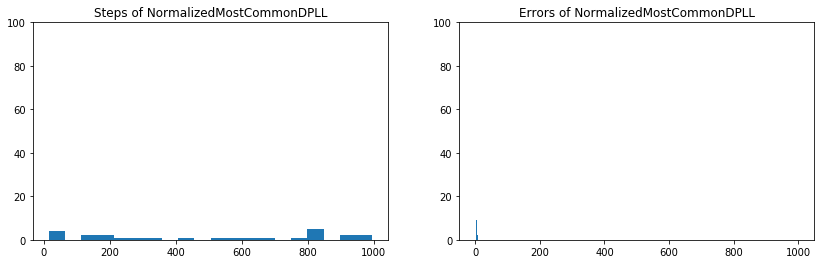

100%|██████████| 100/100 [39:02<00:00, 20.70s/it]


Within 1000 steps solved 72 problems out of 100
#Sats: 72; avg step: 376.31; stdev step: 281.90; avg error: 2.72; stdev error: 1.12


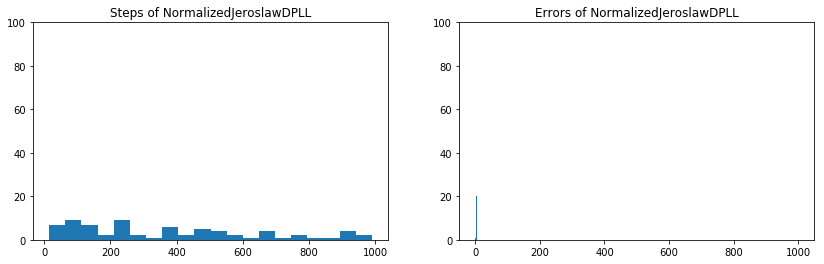

In [25]:
print_all(100, 1000, 70, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [10:56:04<00:00, 163.66s/it]


Within 1000 steps solved 2 problems out of 100
#Sats: 2; avg step: 273.00; stdev step: 20.00; avg error: 1.50; stdev error: 0.50


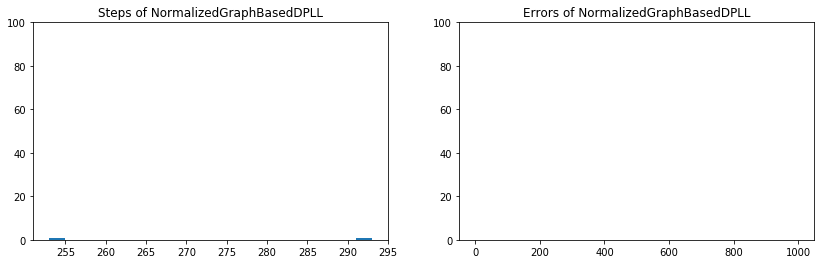

100%|██████████| 100/100 [15:57<00:00,  9.28s/it]


Within 1000 steps solved 7 problems out of 100
#Sats: 7; avg step: 355.86; stdev step: 257.68; avg error: 3.71; stdev error: 1.83


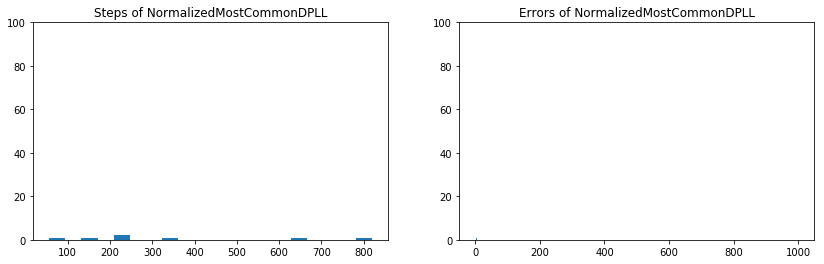

100%|██████████| 100/100 [12:57<00:00,  5.78s/it]


Within 1000 steps solved 36 problems out of 100
#Sats: 36; avg step: 341.53; stdev step: 312.67; avg error: 2.33; stdev error: 1.22


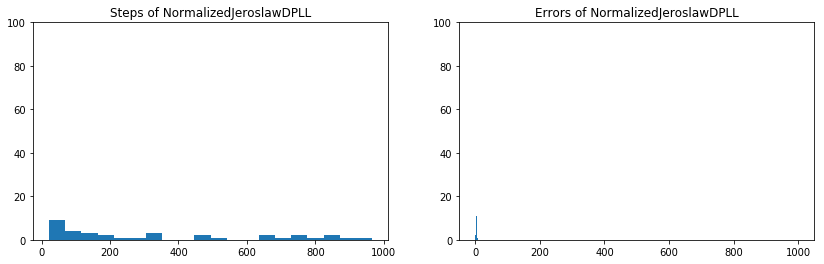

In [26]:
print_all(100, 1000, 90, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [3:43:03<00:00, 120.57s/it]
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/michal/deepsat/venv/lib/python3.5/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Within 1000 steps solved 0 problems out of 100
#Sats: 0; avg step: nan; stdev step: nan; avg error: nan; stdev error: nan


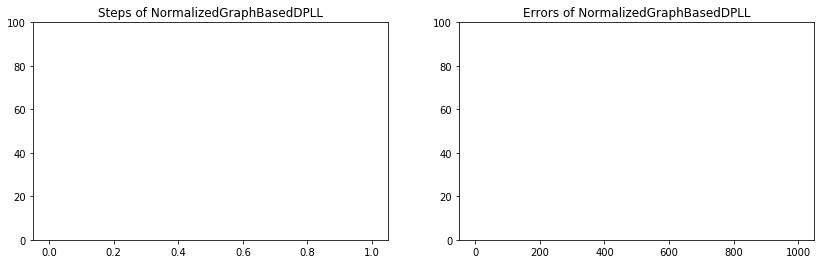

100%|██████████| 100/100 [14:06<00:00,  8.67s/it]


Within 1000 steps solved 2 problems out of 100
#Sats: 2; avg step: 489.50; stdev step: 436.50; avg error: 3.00; stdev error: 1.00


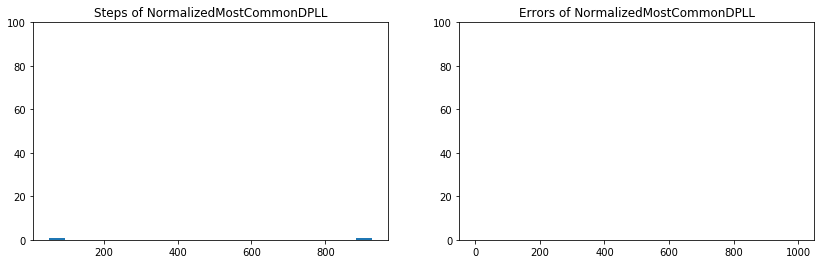

100%|██████████| 100/100 [12:33<00:00,  5.75s/it]


Within 1000 steps solved 11 problems out of 100
#Sats: 11; avg step: 240.73; stdev step: 183.18; avg error: 2.82; stdev error: 0.83


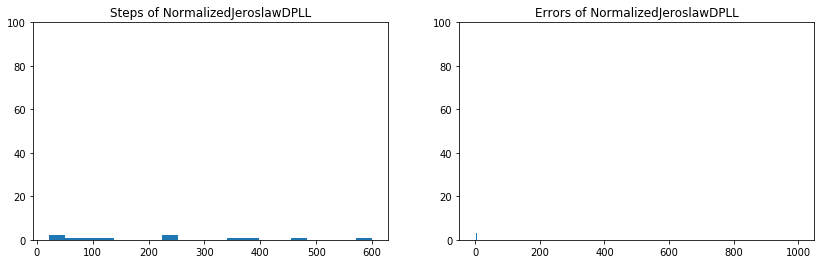

In [27]:
print_all(100, 1000, 110, light=True)